In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
%matplotlib inline

Определите AUC_ROC и AUC_PR для модели логистической регрессии на тестовой выборке. Используйте реализацию модели в виде класса и функцию confusion, чтобы рассчитать TPR, FPR, precision, recal для различных порогов вероятности.

In [2]:
class LogisticRegression:
    def __init__(self, n_iterations=1000, eta=0.05):
        self.n_iterations = n_iterations
        self.eta = eta

    def _log_grad(self, X, target):
        m = X.shape[0]
        y = (2 * target - 1)
        score = np.dot(X, self.w.T).flatten() + self.w0
        Z = -y / (m * (1 + np.exp(y * score)))
        grad = Z[np.newaxis, :].dot(X)
        return grad / m, np.sum(Z) / m

    def _optimize(self, X, target):
        for i in range(self.n_iterations):
            grad_w, grad_w0 = self._log_grad(X, target)
            self.w -= self.eta * grad_w
            self.w0 -= self.eta * grad_w0

    def fit(self, X, target):
        self.w = np.zeros((1, X.shape[1]))
        self.w0 = 0
        self._optimize(X, target)

    def predict_proba(self, X):
        score = X.dot(self.w.T).flatten() + self.w0
        return 1 / (1 + np.exp(-score))

    def predict(self, X, thr=0.5, exact_proba=False):
        """
        При exact_proba=True возвращает значения вероятности целевой 
        переменной без отнесения к классу
        """
        proba = self.predict_proba(X)
        y_predicted = np.zeros(proba.shape, dtype=np.int8)
        y_predicted[proba > thr] = 1
        y_predicted[proba <= thr] = 0
        return y_predicted if not exact_proba else proba

    @staticmethod
    def _confusion(y_predicted, y_actual):
        """
        :param y_predicted: predicted target value
        :param y_actual: real target value
        :return: tuple of following true positive, false positive,
                 true negative and false negative
        """
        TP = np.sum(np.logical_and(y_predicted == 1, y_actual == 1))
        FP = np.sum(np.logical_and(y_predicted == 1, y_actual == 0))
        TN = np.sum(np.logical_and(y_predicted == 0, y_actual == 0))
        FN = np.sum(np.logical_and(y_predicted == 0, y_actual == 1))
        return TP, FP, TN, FN

    def metrics(self, y_predicted, y_actual, metric='tpr_fpr'):
        """
        Возвращает значение требуемой метрики (f1, tpr_fpr, pr_rec)
        """
        TP, FP, TN, FN = self._confusion(y_predicted, y_actual)
        if TP or FP:
            precision = TP / (TP + FP)
        else:
            precision = 0
        if TP or FN:
            recall = TP / (TP + FN)
        else:
            recall = 0
        if precision or recall:
            f1 = 2 * precision * recall / (precision + recall)
        else:
            f1 = 0
        TPR = recall
        FPR = FP / (FP + TN)
        if metric == 'tpr_fpr':
            return TPR, FPR
        elif metric == 'f1':
            return f1
        elif metric == 'pr_rec':
            return precision, recall
        else:
            print('wrong metric id used')
            return None

    def roc_auc(self, X, y, metric='tpr_fpr'):
        """
        Возращает два ndarray со значениями TPR/recall и FPR/precision 
        по каждому значению порога от 0 до 1 с шагом 0.1 и площадь под кривой.
        Метрика определяется значением metric (tpr_fpr, pr_rec)
        """
        tpr_recall_list = []
        fpr_precision_list = []
        for _i in np.arange(0, 1.1, 0.1):
            y_pred = self.predict(X, thr=np.around(_i, 1))
            _tpr, _fpr = self.metrics(y_pred, y, metric)
            tpr_recall_list.append(_tpr)
            fpr_precision_list.append(_fpr)
        TPR_REC = np.array(tpr_recall_list)
        FPR_PRC = np.array(fpr_precision_list)
        AUC_ROC = np.sum((FPR_PRC[:-1] - FPR_PRC[1:]) * (TPR_REC[1:] + TPR_REC[:-1]) / 2)
        return TPR_REC, FPR_PRC, AUC_ROC

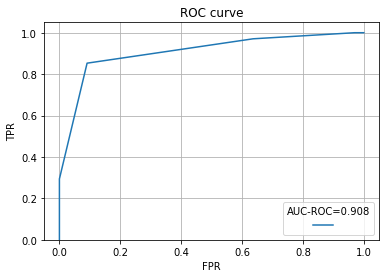

In [3]:
X, y = datasets.make_classification(n_samples=100,
                                    n_features=2,
                                    n_informative=2,
                                    n_redundant=0,
                                    n_classes=2,
                                    random_state=56)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=2,
                                                    shuffle=True)
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)
tpr, fpr, auc = log_reg_model.roc_auc(X_train, y_train)
plt.title('ROC curve')
plt.ylim(0, 1.05)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.plot(fpr, tpr)
plt.legend(' ', title=f'AUC-ROC={auc:.3f}', loc='lower right')
plt.show()

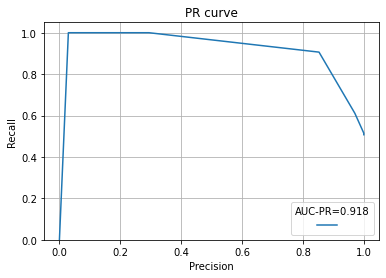

In [4]:
tpr, fpr, auc = log_reg_model.roc_auc(X_train, y_train, metric='pr_rec')
plt.title('PR curve')
plt.ylim(0, 1.05)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid()
plt.plot(fpr, tpr)
plt.legend(' ', title=f'AUC-PR={auc:.3f}', loc='lower right')
plt.show()

In [5]:
log_reg_model.metrics(log_reg_model.predict(X_test), y_test, 'f1')

0.8823529411764706